In [1]:
from src.v1.symbolic import Var, Par
from src.v3.nesting import edges_no_param
from src.v4.problem import Subproblem, intersection
from dev.sandbox.v4.constants import μ, R, Q, c, k
import numpy as np
import sympy as sp

In [2]:
P1 = Subproblem('orbit')
h = Var('h', 400, 'km') #
a = P1.Var('a', h + R, unit='km')
T = P1.Var('T', 2*np.pi*(a**3/μ)**0.5, unit='min')
g = P1.Var('g', 1/np.pi*sp.acos(R/a), unit='')
d = P1.Var('d', g+0.5)
r = P1.Var('r', (h**2+2*R*h)**0.5, unit='km')

P2 = Subproblem('power')
eta_A = Par(r'\eta_A', 0.3)
rho_A = Par(r'\rho_A', 10, 'kg/m^2')   # Solar array surface density
rho_b = Par(r'\rho_b', 0.002, 'kg/kJ') # Battery energy density
P_l = Par('P_l', 12, 'W')
A = Var('A', 0.05, unit='m^2')
m_A = P2.Var('m_A', rho_A*A, unit='kg') #mass solar array
P_c = P2.Var('P_c', d*A*Q*eta_A, unit='W')
P_T = P2.Var('P_T', P_c-P_l, unit='W') #hack
E_b = P2.Var('E_b', P_c*T/d, unit='kJ')
m_b = P2.Var('m_b', rho_b*E_b, unit='kg')

P3 = Subproblem('payload')
l_v = Par('l_v', 500, 'nm')
N = Par('N', 2e3, '')
B = Par('B', 8, 'bit')
rho_p = Par(r'\rho_p', 2, 'kg/m^1.5') 
X_r = Var('X_r', 5, 'm')
D_p = P3.Var('D_p', 1.22*l_v*h/X_r)
D = P3.Var('D', 2*np.pi*R*B*N/X_r, unit='GB')
m_p = P3.Var('m_p', rho_p*D_p**1.5, unit='kg')

P4 = Subproblem('comms')
dBtoLinear = lambda db: 10**(db/10)
f = Par('f', 2.2, 'GHz')
D_r = Par('D_r', 5.3, 'm')
eta = Par(r'\eta_c', 0.55)
G_T = Par('G_T', dBtoLinear(16.5), '')
L = Par('L', dBtoLinear(1+8.5+0.3+0.1))
T_s = Par('T_s', 135, 'K')
rho_T = Par(r'\rho_T', 0.2, 'kg/m^1.5')
b = P4.Var('b', D/(g*T), unit='MB/s')
λ_c = P4.Var(r'\lambda_c', c/f, unit='cm')
D_T = P4.Var('D_T', λ_c*(G_T/eta)**0.5/np.pi, unit='m')
m_T = P4.Var('m_T', rho_T*D_T**1.5, unit='kg')
G_r = P4.Var('G_r', eta*(np.pi*D_r/λ_c)**2)
EN = P4.Var('EN', P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2, unit='')

P5 = Subproblem('struct')
mt = Var('m_t', unit='kg')
eta_S = Par(r'\eta_S', 0.2)
m_s = P5.Var('m_s', eta_S*mt, unit='kg')

P6 = Subproblem('mass')
m_pr = Var('m_{pr}', 0.5, unit='kg')
P6.add_equation(mt, m_p+m_b+m_A+m_s+m_pr)

m_t

In [3]:
[vr for vr in P4.projected if not vr.always_input], P4.independent

([D, g, T, P_T, r], [b, \lambda_c, D_T, m_T, G_r, EN])

In [4]:
# P2.solve(lookup_projected=True) # plug in for Var and Par values that have already been set
# P2.solve({A: 0.1}, lookup_projected=True) # plug in for Var and Par values that have already been set, override any values in the dictionary
# P2.solve({A: 0.5}, lookup_projected=True, save_projected=True) # plug in for Var and Par values that have already been set, override any values in the dictionary, and save these values to the existing Var

In [5]:
subproblems = [P1, P2, P3, P4, P5, P6]
P = intersection(*subproblems, mergesets=False)

In [6]:
from src.v2.execution import edges_from_components
from graph.matrixview import render_incidence

In [7]:
subproblem = P
edges = edges_from_components(subproblem.components)
tree = subproblem.Ftree, subproblem.Stree, subproblem.Vtree

In [8]:
from src.v2.runpipeline import run_valid_formulation
from graph.graphutils import VAR, COMP, SOLVER

In [9]:
solver_options = {P.id: {'solver':'N', 'iprint': True}}
solver_options.update({P.id: {'solver':'N', 'iprint': False } for P in subproblems})
comp_options = {}
var_options = {}
nametyperepr = {VAR: '{}', COMP: 'f{}', SOLVER: 's{}'}
prob, mdao_in, groups = run_valid_formulation(edges, tree, P.components, solver_options, comp_options, var_options, nametyperepr)
P.prob = prob

In [10]:
coupled_sol = P.solve_with_engine({h:400, A:0.07})


==
s6
==
+  
+  =====
+  s6.s0
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s2
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s3
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s4
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s5
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s0
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s2
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s3
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s4
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s5
+  =====
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations


In [11]:
P4.solve(coupled_sol)

{b: array(26.26379288),
 \lambda_c: array(13.59090909),
 D_T: array(0.38986773),
 m_T: array(0.04868621),
 G_r: array(8255.00154877),
 EN: array(11.79709497)}

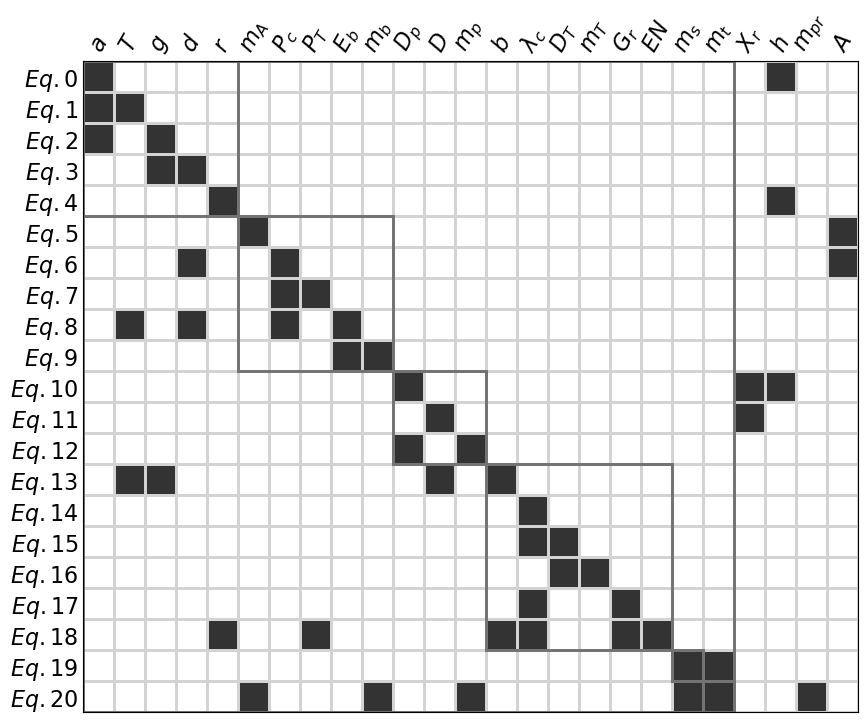

In [12]:
from collections import namedtuple
from itertools import chain
Model = namedtuple('Model', 'idmapping')
render_incidence(edges_no_param(Model({str(v): v for v in chain(P.projected, P.independent)}), edges), tree, rawvarname=True, figsize=(10, 10), diagonalgray=False, hideticks=True);

In [13]:
from src.v4.problem import problem

In [15]:
objective_function = mt
EbNoreq = Par('EN_r', 14.125)
inequalities = [-EN+EbNoreq]
discipline_set = [P1, P2, P3, P4, P5, P6]
merged_discipline = intersection(*discipline_set, mergesets=False)
P = problem(mt, inequalities, [merged_discipline], flatten=False) # IDF strategy

In [16]:
P.solver_options, P.comp_options

({7: {'type': OPT}}, {21: OBJ, 22: NEQ})

In [17]:
edges = edges_from_components(P.components)
# edges_no_par = edges_no_param(Model({str(v): v for v in chain(P.projected, P.independent)}), edges)
tree = P.Ftree, P.Stree, {'h': 1, 'A':1}
solver_options = P.solver_options
comp_options = P.comp_options
var_options = {}

In [18]:
nametyperepr = {VAR: '{}', COMP: 'f{}', SOLVER: 's{}'}
prob, mdao_in, groups = run_valid_formulation(edges, tree, P.components, solver_options, comp_options, var_options, nametyperepr)

In [19]:
P.prob = prob
P.solve_with_engine({h:400, A:0.07})


==
s6
==
+  
+  =====
+  s6.s0
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s1
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s2
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s3
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s4
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s5
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s0
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s1
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s2
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s3
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s4
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s5
+  =====
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 1 iterations


{a: array([6778.]),
 T: array([92.55759153]),
 g: array([0.1099015]),
 d: array([0.6099015]),
 r: array([2293.99215343]),
 m_A: array([0.7]),
 P_c: array([17.50844246]),
 P_T: array([5.50844246]),
 E_b: array([159.4230468]),
 m_b: array([0.31884609]),
 D_p: array([0.0488]),
 D: array([16.02966236]),
 m_p: array([0.02156054]),
 b: array([26.26379288]),
 \lambda_c: array([13.59090909]),
 D_T: array([0.38986773]),
 m_T: array([0.04868621]),
 G_r: array([8255.00154877]),
 EN: array([11.79709497]),
 m_s: array([0.38510166]),
 m_t: array([1.9255083])}

In [20]:
prob.run_driver()


==
s6
==
+  
+  =====
+  s6.s0
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s1
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s2
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s3
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s4
+  =====
+  NL: Newton Converged in 0 iterations
+  
+  =====
+  s6.s5
+  =====
+  NL: Newton Converged in 0 iterations
NL: Newton Converged in 0 iterations


ValueError: not enough values to unpack (expected 2, got 0)

In [21]:
prob.list_problem_vars()

----------------
Design Variables
----------------
name  val  size  
----  ---  ---- 

-----------
Constraints
-----------
name   val           size  
-----  ------------  ---- 
neq22  [2.32790503]  1     

----------
Objectives
----------
name   val          size  
-----  -----------  ---- 
obj21  [1.9255083]  1     



In [22]:
output = {var:np.array(prob.get_val(str(var))) for var in P.independent}

In [23]:
output

{a: array([6778.]),
 T: array([92.55759153]),
 g: array([0.1099015]),
 d: array([0.6099015]),
 r: array([2293.99215343]),
 m_A: array([0.7]),
 P_c: array([17.50844246]),
 P_T: array([5.50844246]),
 E_b: array([159.4230468]),
 m_b: array([0.31884609]),
 D_p: array([0.0488]),
 D: array([16.02966236]),
 m_p: array([0.02156054]),
 b: array([26.26379288]),
 \lambda_c: array([13.59090909]),
 D_T: array([0.38986773]),
 m_T: array([0.04868621]),
 G_r: array([8255.00154877]),
 EN: array([11.79709497]),
 m_s: array([0.38510166]),
 m_t: array([1.9255083])}

In [24]:
P6.solve(output)

{m_t: array(1.9255083)}

In [ ]:
# intersection(P1, P2) is the same as P2.eliminate(P1) when it is already feedforward
# P6.eliminate(P5)